<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/Behaviour_Classification_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seabird Diving Behaviour with GPS data


Auto Encoder with Deep Networks


## Data Formatting

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import random
import pickle
import datetime

In [2]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# connect to database
conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')

In [4]:
request = "SELECT DISTINCT lon, lat FROM fieldwork WHERE place='Pescadores'"
colony = pd.read_sql_query(request, conn)
colony = colony.values
colony

array([[-77.264, -11.773]])

In [5]:
request = "SELECT \
            trip.id as trip, gps.datetime, gps.lon, gps.lat\
            FROM gps \
            INNER JOIN trip ON gps.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND substr(bird.fieldwork,1,1) = 'P' \
            AND bird.species = 'SV'"

# substr(bird.fieldwork,1,1) = 'P'

gps = pd.read_sql_query(request, conn)
gps

,trip,datetime,lon,lat
0,P1108_1_SV_T1,2008-11-23 12:53:38,-77.265178,-11.775134
1,P1108_1_SV_T1,2008-11-23 12:53:39,-77.265222,-11.775064
2,P1108_1_SV_T1,2008-11-23 12:53:40,-77.265312,-11.774998
3,P1108_1_SV_T1,2008-11-23 12:53:41,-77.265384,-11.774966
4,P1108_1_SV_T1,2008-11-23 12:53:42,-77.265506,-11.774930
...,...,...,...,...
2130760,P1115_25_SV_T1,2015-11-28 20:26:40,-77.258705,-11.770595
2130761,P1115_25_SV_T1,2015-11-28 20:26:41,-77.258766,-11.770683
2130762,P1115_25_SV_T1,2015-11-28 20:26:42,-77.258850,-11.770755
2130763,P1115_25_SV_T1,2015-11-28 20:26:43,-77.258934,-11.770796


In [6]:
# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)

In [7]:
gps[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]

,trip,datetime,lon,lat
717806,P1110_54_SV_T5,2010-12-05 17:24:55,-77.387550,-11.448993
717808,P1110_54_SV_T5,2010-12-05 17:24:55,-77.387503,-11.448995


In [8]:
# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)

In [9]:
gps[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]

,trip,datetime,lon,lat


In [10]:
gps['datetime'] = pd.to_datetime(gps['datetime'], format='%Y-%m-%d %H:%M:%S')

In [11]:
# check NaN and fill with interpolations
[i for i, x in enumerate(gps['lon'].isna()) if x]


gps['lon'] = gps['lon'].interpolate(method='polynomial', order=2)
gps['lat'] = gps['lat'].interpolate(method='polynomial', order=2)

In [12]:
len(gps.trip.unique())

560

In [13]:
def dist_ortho(lon1, lat1, lon2, lat2):
    R = 6377726
    pi = np.pi
    a = np.sin((lat1 - lat2)/2*pi/180)**2
    b = np.cos(lat1*pi/180)*np.cos(lat2*pi/180)
    c = np.sin((lon1- lon2)/2* pi/180)**2
    
    dist = R * 2* np.arcsin( np.sqrt(a + b*c))
    return dist

def cap(lon1, lat1, lon2, lat2):
    pi = np.pi
    
    # to radians
    lat1 = lat1*pi/180
    lat2 = lat2*pi/180
    lon1 = lon1*pi/180
    lon2 = lon2*pi/180
    
    delta_lon = lon2-lon1
    
    a = np.cos(lat1) * np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(delta_lon)
    b = np.sin(delta_lon) * np.cos(lat2)
    
    cap = np.arctan2(b , a)
    cap = cap%(2*pi)
    
    return cap*180/pi

class Trip:
    def __init__(self, df):
        
        self.df = df.set_index(np.arange(len(df)))  
        
        # matrix of distance
#         self.dist_matrix = np.zeros((len(self.df), len(self.df)))
    
    ### GENERAL STATISTICS ### -----------------------------------------------
    
    def get_duration(self):
        return max(self.df.datetime) - min(self.df.datetime)
    
    def get_distance(self):
        return sum(self.get_step())/1e3
    
    ### STEP-ANGLE PAIRS ### -----------------------------------------------
    
    def get_step(self):
        n = len(self.df)
        step = dist_ortho( self.df.lon.values[0:(n-1)], self.df.lat.values[0:(n-1)], self.df.lon.values[1:n], self.df.lat.values[1:n])
        return step
    
    def add_step(self):
        self.df['step'] = np.append(np.nan, self.get_step())
        
    def get_cap(self):
        n = len(self.df)
        c = cap( self.df.lon.values[0:(n-1)], self.df.lat.values[0:(n-1)], self.df.lon.values[1:n], self.df.lat.values[1:n])
        return c
    
    def add_cap(self):
        self.df['cap'] = np.append(np.nan, self.get_cap())
 
    def get_direction(self):
        direction = [d%360 - 360 if d%360 > 180 else d%360 for d in np.diff(self.get_cap())]
        return np.array(direction)
    
    def add_direction(self):
        a = np.empty(2)
        a.fill(np.nan)
        self.df['direction'] = np.append(a, self.get_direction())
      
    def plot(self):
                
        plt.figure(figsize=(12, 3))

        plt.subplot(1, 2, 1)
        plt.plot(self.df.lon.values, self.df.lat.values)
        
        plt.subplot(1, 2, 2)
        plt.scatter(self.df.direction, self.df.step, alpha = 0.3)
        
    
    ### AREA RESTRICTED RESEARCH ### -----------------------------------------------
    
    def compute_dist_matrix(self, verbose=True):
        for i in range(len(self.df)):
            lon1 = self.df.lon[[i for j in range(len(self.df))]]
            lat1 = self.df.lat[[i for j in range(len(self.df))]]
            lon2 = self.df.lon[[j for j in range(len(self.df))]]
            lat2 = self.df.lat[[j for j in range(len(self.df))]]

            self.dist_matrix[i, :] = dist_ortho(lon1.values, lat1.values, lon2.values, lat2.values)
            
            if verbose:
                IPython.display.clear_output(wait=True)
                print('Distance [{}/{}]'.format(i, len(self.df)))
                
    
    def residence_time(self, radius):
        residence_matrix = self.dist_matrix < radius
        residence = [sum(residence_matrix[:,i]) for i in range(len(self.df))]
        
        return residence
    
    def first_time_passage(self, radius):
        first_passage = np.zeros(len(t.df))
        residence_matrix = self.dist_matrix < radius
        
        for i in range(len(self.df)):

            idx = np.where(residence_matrix[:,i])[0]
            delta = np.diff(idx)
            
            # get index start
            i_start = i
            while i_start in idx:
                i_start -=1
            
            # get index end
            i_end = i
            while i_end in idx:
                i_end +=1
                
            # get number of point
            first_passage[i] = i_end-i_start+1
            
        return first_passage
    ### -----------------------------------------------

In [14]:
# path_folder = "./trajectory_all/"

# for t in gps.trip.unique():
    
#     path_file = path_folder + t
#     df_trip = gps[gps.trip == t]
    
#     t = Trip(df_trip)
#     t.add_step()
#     t.add_direction()
    
#     t.plot()
#     plt.savefig(path_file)
#     plt.close()

In [15]:
bad_trip = ['P1108_2_SV_T3', 'P1108_14_SV_T1', 'P1108_14_SV_T3',
            'P1108_19_SV_T1', 'P1108_19_SV_T2', 'P1108_24_SV_T2',
            'P1108_24_SV_T4', 'P1108_33_SV_T3', 'P1108_38_SV_T5',
            'P1108_39_SV_T2', 'P1108_41_SV_T3', 'P1108_41_SV_T4',
            'P1109_9_SV_T2', 'P1109_16_SV_T5', 'P1110_24_SV_T1',
            'P1110_24_SV_T2', 'P1110_43_SV_T6', 'P1110_47_SV_T2',
            'P1110_47_SV_T4', 'P1110_51_SV_T6', 'P1110_52_SV_T6',
            'P1110_59_SV_T4', 'P1110_59_SV_T6', 'P1110_59_SV_T7',
            'P1110_62_SV_T3', 'P1110_62_SV_T4', 'P1110_64_SV_T1',
            'P1110_64_SV_T2', 'P1110_64_SV_T5', 'P1110_64_SV_T8',
            'P1110_67_SV_T2', 'P1111_41_SV_T5', 'P1111_46_SV_T5',
            'P1112_36_SV_T2', 'P1113_50_SV_T2', 'P1115_SV_T1'          
           ]

In [16]:
### remove bad data
idx = gps.index[[(t in bad_trip) for t in gps.trip]]
df = gps.drop(idx)

In [17]:
len(df.trip.unique())

525

## Dive Prediction

In [18]:
# standardized trajectories
gps['lon_std'] = (gps['lon'] - np.mean(gps['lon']))/np.std(gps['lon'])
gps['lat_std'] = (gps['lat'] - np.mean(gps['lat']))/np.std(gps['lat'])
gps

,trip,datetime,lon,lat,lon_std,lat_std
0,P1108_1_SV_T1,2008-11-23 12:53:38,-77.265178,-11.775134,0.756738,-0.263899
1,P1108_1_SV_T1,2008-11-23 12:53:39,-77.265222,-11.775064,0.756414,-0.263396
2,P1108_1_SV_T1,2008-11-23 12:53:40,-77.265312,-11.774998,0.755752,-0.262921
3,P1108_1_SV_T1,2008-11-23 12:53:41,-77.265384,-11.774966,0.755223,-0.262690
4,P1108_1_SV_T1,2008-11-23 12:53:42,-77.265506,-11.774930,0.754326,-0.262431
...,...,...,...,...,...,...
2130760,P1115_25_SV_T1,2015-11-28 20:26:40,-77.258705,-11.770595,0.804336,-0.231238
2130761,P1115_25_SV_T1,2015-11-28 20:26:41,-77.258766,-11.770683,0.803887,-0.231871
2130762,P1115_25_SV_T1,2015-11-28 20:26:42,-77.258850,-11.770755,0.803269,-0.232389
2130763,P1115_25_SV_T1,2015-11-28 20:26:43,-77.258934,-11.770796,0.802652,-0.232684


In [19]:
trajs = []
n = 0
for trip in gps.trip.unique():
    df_trip = gps[gps.trip == trip]
    trajs.append(df_trip)
    n +=1
    
    IPython.display.clear_output(wait=True)
    print('Trip [{}/{}]'.format(n, len(gps.trip.unique())))

Trip [560/560]


## Neural Network

In [20]:
# general material
import numpy as np
import matplotlib.pyplot as plt
import pickle

# pytorch materials
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [21]:
class Sampler:
  def __init__(self, trajs, epoch, batch_size):
    # raw trajectories
    self.trajs = trajs
    self.n = len(trajs)
    # sample input specificities
    self.epoch = epoch
    self.batch_size = batch_size

  def sample(self):
    batch = []
    for i in range(self.batch_size):
      # look for a long trip
      dt = []
      while len(dt) < epoch:
        traj_idx = np.random.randint(self.n)
        dt = self.trajs[traj_idx]

      # select part of this trip
      epoch_idx = np.random.randint(len(dt)-epoch)
      extracted_trajs = dt.iloc[epoch_idx:epoch_idx+100, 4:6]

      # add it to batch
      batch.append(extracted_trajs.to_numpy().T)

    return torch.FloatTensor(batch)


In [22]:
# Hyperparameters
epoch = 100
batch_size = 8
learning_rate = 0.001

extracted_traj = Sampler(trajs, epoch, batch_size)
input = extracted_traj.sample()
input.size()

torch.Size([8, 2, 100])

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(2, 10, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.Linear(100, 100),
            nn.Conv1d(10, 10, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.Linear(100, 100),
            nn.Conv1d(10, 5, kernel_size = 6, stride = 1, padding = 5, dilation = 2),
            nn.Linear(100, 100),
            nn.Softmax(dim = 1)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.Conv1d(5, 10, kernel_size = 6, stride = 1, padding = 5, dilation = 2),
            nn.Linear(100, 100),
            nn.Conv1d(10, 10, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.Linear(100, 100),
            nn.Conv1d(10, 2, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
        )

        
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [25]:
model = ConvNet()
out = model(input)
out.size()

torch.Size([8, 2, 100])

In [26]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
criterion(out, input)

tensor(0.8077, grad_fn=<MseLossBackward>)

In [31]:
## estimate a relevant nb of total step
total_step = round(0.7 * (len(gps) - len(gps.trip.unique()) * epoch)/batch_size)
total_step

179884

In [32]:
# Train the model
loss_list = []
acc_list = []

for i in range(total_step):
    
    # Train the model
    model.train()
    
    # Run the forward pass
    x = extracted_traj.sample() 
    output = model(x)
    loss = criterion(output, x)

    # Backprop and perform optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
       
    if i%1000 ==0:
        print('Step [{}/{}], Loss: {:.4f}'
              .format(i + 1, total_step, loss.item()))

Step [1/179884], Loss: 0.0061
Step [1001/179884], Loss: 0.0006
Step [2001/179884], Loss: 0.0122
Step [3001/179884], Loss: 0.0001
Step [4001/179884], Loss: 0.0011
Step [5001/179884], Loss: 0.0191
Step [6001/179884], Loss: 0.0008
Step [7001/179884], Loss: 0.0041
Step [8001/179884], Loss: 0.0011
Step [9001/179884], Loss: 0.0013
Step [10001/179884], Loss: 0.0029
Step [11001/179884], Loss: 0.0010
Step [12001/179884], Loss: 0.0046
Step [13001/179884], Loss: 0.0035
Step [14001/179884], Loss: 0.0018
Step [15001/179884], Loss: 0.0004
Step [16001/179884], Loss: 0.0033
Step [17001/179884], Loss: 0.0001
Step [18001/179884], Loss: 0.0005
Step [19001/179884], Loss: 0.0009
Step [20001/179884], Loss: 0.0002
Step [21001/179884], Loss: 0.0103
Step [22001/179884], Loss: 0.0069
Step [23001/179884], Loss: 0.0001
Step [24001/179884], Loss: 0.0001
Step [25001/179884], Loss: 0.0082
Step [26001/179884], Loss: 0.0034
Step [27001/179884], Loss: 0.0002
Step [28001/179884], Loss: 0.0004
Step [29001/179884], Loss: 

In [33]:
true = extracted_traj.sample()
estim = model(true).detach()

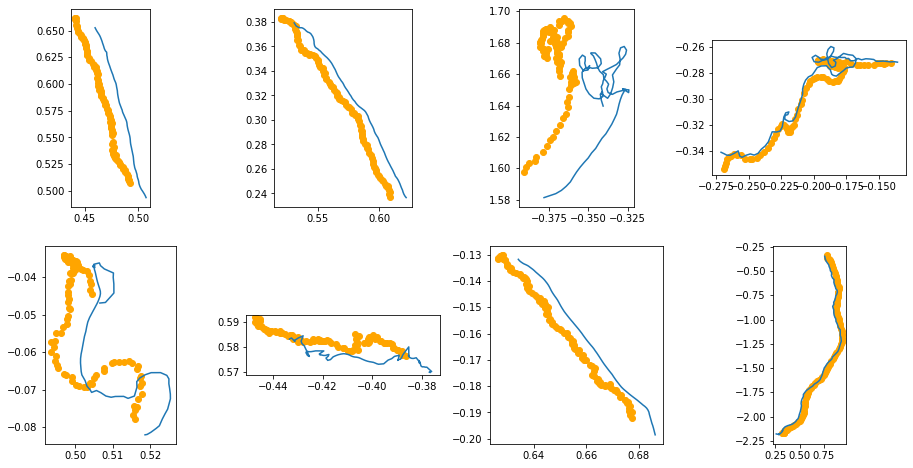

In [34]:
plt.figure(figsize=(16, 8))

for i in range(8):
    
    pos_true = true[i]
    pos_estim = estim[i]
    
    
    plt.subplot(2, 4, i+1)
    plt.plot(pos_true[0].numpy(), pos_true[1].numpy())
    plt.scatter(pos_estim[0].numpy(), pos_estim[1].numpy(), c = 'orange')
    
        #selecting the current axis
    ax = plt.gca()
    ax.set_aspect(1)